<a href="https://www.kaggle.com/code/m000sey/ps-3-25-predicting-hardness?scriptVersionId=151415034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

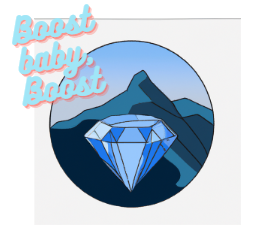

### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Preface</span>

- I'm still working hard on this notebook.
- Things to note:
    - So far single models have worked far better than blending, voting, stacking, and mixing those together. XGB and LGBM are the best for me.
    - I changed up my optuna routine to use train_test_split, which may have given me some good params
        - BUT I haven't tried these for blending,voting, stacking, or mixing
    - I have a bunch of stuff I want to try, which I'll list at the end of my notebook. Enjoy this competition and I'll see you in the discussion.


In [1]:
### Import libraries and select file path
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import yeojohnson
from catboost import CatBoostRegressor
import catboost
from lightgbm import LGBMRegressor
import lightgbm
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import time, optuna, warnings, os, platform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
!pip install -q scikit-lego
from sklego.linear_model import LADRegression
!pip install xgboost==2.0.0
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

if platform.system()   == "Windows":
    train_path          = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/train.csv'
    test_path           = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/test.csv'
    sample_path         = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/sample_submission.csv'
    original_1_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_1.csv'
    original_2_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_2.csv'
    print("Using Windows file path...")
elif platform.system() == "Darwin":
    train_path          = '/Users/shane/Documents/data_science/train.csv'
    test_path           = '/Users/shane/Documents/data_science/test.csv'
    print("Using Mac file path...")
elif platform.system() == "Linux":
    train_path          = '/kaggle/input/playground-series-s3e25/train.csv'
    test_path           = '/kaggle/input/playground-series-s3e25/test.csv'
    sample_path         = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
    original_1_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv'
    original_2_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv'
    print("Using Linux file path...")
else:
    raise OSError("Unsupported operating system")
    
train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
sample = pd.read_csv(sample_path)
original_1 = pd.read_csv(original_1_path)
original_2 = pd.read_csv(original_2_path)

# reconfigure some of the original data
original_1 = original_1[(original_1 == 0).sum(axis=1) <= 2]
original_1 = original_1.dropna(subset=['Crystal structure'])
original_1 = original_1.drop(['Unnamed: 0', 'Formula'], axis=1)
original_2 = original_2.drop(['Unnamed: 0'], axis=1)
column_order = [col for col in original_2.columns if col != 'Hardness'] + ['Hardness']
original_2 = original_2[column_order]

# Drop duplicates
duplicates_original_2 = original_2.duplicated().sum()
print("pre-drop  duplicates in original_2:", duplicates_original_2)
original_2 = original_2.drop_duplicates()
duplicates_original_2 = original_2.duplicated().sum()
print("post-drop duplicates in original_2:", duplicates_original_2)

# add the original data to the synthetic
train = pd.concat([original_2, train])
train = train.reset_index(drop=True)

# rename some columns to make me more happy
def rename_cols(df):
    df.rename(columns={'allelectrons_Total': 'num_electrons'}, inplace=True)
    df.rename(columns={'density_Total': 'total_density'}, inplace=True)
    df.rename(columns={'allelectrons_Average': 'avg_electrons'}, inplace=True)
    df.rename(columns={'val_e_Average': 'avg_val_e'}, inplace=True)
    df.rename(columns={'atomicweight_Average': 'avg_at_wt'}, inplace=True)
    df.rename(columns={'ionenergy_Average': 'avg_ion_energy'}, inplace=True)
    df.rename(columns={'el_neg_chi_Average': 'avg_electroneg'}, inplace=True)
    df.rename(columns={'R_vdw_element_Average': 'avg_vdw_rad'}, inplace=True)
    df.rename(columns={'R_cov_element_Average': 'avg_cov_rad'}, inplace=True)
    df.rename(columns={'zaratio_Average': 'avg_PtoN'}, inplace=True)
    df.rename(columns={'density_Average': 'avg_density'}, inplace=True)
    return df
train = rename_cols(train)
test = rename_cols(test)
original_1 = rename_cols(original_1)

print("Data added...")

  Obtaining dependency information for xgboost==2.0.0 from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.1
    Uninstalling xgboost-2.0.1:
      Successfully uninstalled xgboost-2.0.1
2.0.1
Using Linux file path...
pre-drop  duplicates in original_2: 23
post-drop duplicates in original_2: 0
Data added...




<a id="table"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table of contents</span>

[1. Overview](#1)

[2. KNN](#2)

[3. EDA](#3)

[4. Scale & FE](#4)

[5. Optuna](#5)

[6. Blending](#6)

[7. Voting](#7)

[8. Stacking](#8)

[9. Submission w/ mixing](#9)

[10. TO DO LIST](#10)

<a id="1"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;"> Overview </span>
> **Note:** This notebook isn't even close to being finished, but I figure I may as well practice in public so other's can see what I'm working on

> **1.** Add a crystal structure feature from KNN

> **2.** Conduct EDA

> **3.** Ensemble several models: XGB, LGBM, CAT, HGB via **blending**

> **4.** Ensemble several models: XGB, LGBM, CAT, HGB via **voting**

> **5.** Ensemble several models: XGB, LGBM, CAT, HGB via **stacking**

> **6.** Submit

<a id="2"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">KNN to impute an original feature</span>
-  This KNN was copied directly from the good work in this [notebook](https://www.kaggle.com/code/yantxx/catboost-regressor-mohs-hardness-prediction/notebook) @yantxx

In [2]:
common_columns_df = [col for col in train.columns if col in original_1.columns]
X_original = original_1[common_columns_df]
X_train = train[common_columns_df]

KNN = NearestNeighbors(n_neighbors=1, p=2) # p=2 means we're using the euclidean distance
KNN.fit(X_original)
distances_df, indices_df = KNN.kneighbors(X_train)
train['crystal_strx'] = original_1.iloc[indices_df.flatten()]['Crystal structure'].values

common_columns_test = [col for col in test.columns if col in original_1.columns]
X_test = test[common_columns_test]

distances_test, indices_test = KNN.kneighbors(X_test)
test['crystal_strx'] = original_1.iloc[indices_test.flatten()]['Crystal structure'].values

print("KNN feature created...")

# Assuming 'crystal_strx' is the column you want to encode
label_encoder = LabelEncoder()
train['crystal_strx_encoded'] = label_encoder.fit_transform(train['crystal_strx'])
test['crystal_strx_encoded'] = label_encoder.transform(test['crystal_strx'])

# Drop the original 'Crystal structure' columns
train = train.drop(['crystal_strx'], axis=1)
test = test.drop(['crystal_strx'], axis=1)

column_order = [col for col in train.columns if col != 'Hardness'] + ['Hardness']
train = train[column_order]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
z = test

del train, test, test_path, train_path, original_1_path, original_2_path, column_order, common_columns_df, common_columns_test
del distances_df, distances_test, indices_df, indices_test, KNN, original_1, original_2, X_original, X_test, X_train

KNN feature created...


<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">EDA</span>
coming soon!

In [3]:
# EDA
# pairplot = sns.pairplot(X, corner=True)
# plt.show(pairplot)

<a id="4"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">RobustScaler & Feature Engineering</span>
- I did the robustscaler because of a previous [discussion](https://www.kaggle.com/competitions/playground-series-s3e24/discussion/453997#2520598) with the all powerful @siukeitin

In [4]:
def feature_engineering(df):
    # more to come
    return df

X = feature_engineering(X)
z = feature_engineering(z)
print("Feature engineering complete...")

scaler = RobustScaler()
# X = scaler.fit_transform(X)
# z = scaler.fit_transform(z)
print("Data are scaled...")
print()

Feature engineering complete...
Data are scaled...



<a id="5"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Optuna code</span>
- **Note:** I *never* do optuna in my notebooks, entirely due to run time, but I figured this code could be helpful to some folks
- **Note:** I will put the trial number to 2 for it to run quickly, but on my personal machine I have it set to 1000 (which is probably overkill, realistically, I suggest 500 trials)

In [5]:
SEED = 42
ROUNDS = 100
N_TRIALS = 2
xgb_optuna_scores  = []
lgbm_optuna_scores = []
cat_optuna_scores  = []
hgb_optuna_scores  = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# XGB OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    eta = trial.suggest_float("eta", 0.01, 0.2)
    gamma = trial.suggest_float("gamma", 0.01, 3.0)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-9, 100.0)
    alpha = trial.suggest_float("alpha", 1e-9, 100.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    
    XGB = XGBRegressor(objective='reg:absoluteerror',
                       random_state=SEED,
                       n_jobs=-1,
                       n_estimators=n_estimators,
                       max_depth=max_depth,
                       eta=eta,
                       gamma=gamma,
                       reg_lambda=reg_lambda,
                       alpha=alpha,
                       min_child_weight=min_child_weight,
                       colsample_bytree=colsample_bytree,
                       subsample=subsample,
                       early_stopping_rounds=ROUNDS)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")
        
        XGB.fit(X_train, y_train, 
                eval_metric='mae',
                eval_set = [(X_test,y_test)],
                verbose=False)
    
    xgb_score = median_absolute_error(y_test, XGB.predict(X_test))
    xgb_optuna_scores.append(xgb_score)
    
    return xgb_score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best XGB Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"XGB optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
xgb_params = {'n_estimators': 726, 'max_depth': 10, 'eta': 0.07613804584051358, 'gamma': 1.111993246238503, 
              'reg_lambda': 30.670711937824027, 'alpha': 10.2136072659197, 'min_child_weight': 6, 
              'colsample_bytree': 0.7838805588294807, 'subsample': 0.7366491220918466}

# LGBM OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    num_leaves = trial.suggest_int("num_leaves", 20, 300)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 20, 300)
    max_bin = trial.suggest_int("max_bin", 32, 255)
    lambda_l1 = trial.suggest_float("lambda_l1", 0, 1)
    lambda_l2 = trial.suggest_float("lambda_l2", 0, 1)
    min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 1)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm.sklearn")
    
        LGBM = LGBMRegressor(objective='mae',
                             random_state=SEED,
                             verbose=-1,
                             n_jobs=-1,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             num_leaves=num_leaves,
                             min_child_samples=min_data_in_leaf,
                             max_bin=max_bin,
                             reg_alpha=lambda_l1,
                             reg_lambda=lambda_l2,
                             min_split_gain=min_gain_to_split)
    
        LGBM.fit(X_train, y_train, 
                 eval_metric='mae',
                 eval_set = [(X_test, y_test)],
                 callbacks=[lightgbm.early_stopping(stopping_rounds=ROUNDS, verbose=False)])

    lgbm_score = median_absolute_error(y_test, LGBM.predict(X_test))
    lgbm_optuna_scores.append(lgbm_score)

    return lgbm_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best LGBM params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"LGBM optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 'num_leaves': 47, 
                  'min_data_in_leaf': 20, 'max_bin': 221, 'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833, 
                  'min_gain_to_split': 0.24215691067519887}

# CAT OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    iterations = trial.suggest_int("iterations", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    bagging_temperature=trial.suggest_float('bagging_temperature', 0, 1)
    colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.1, 1)
    l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1, 10)
    min_data_in_leaf=trial.suggest_float('min_data_in_leaf', 1, 30)
    max_bin=trial.suggest_int('max_bin', 2, 255)

    CAT = CatBoostRegressor(random_state=SEED,
                            verbose=0,
                            early_stopping_rounds=ROUNDS,
                            objective='MAE',
                            iterations=iterations,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            bagging_temperature=bagging_temperature,
                            colsample_bylevel=colsample_bylevel,
                            l2_leaf_reg=l2_leaf_reg,
                            min_data_in_leaf=min_data_in_leaf,
                            max_bin=max_bin)
    
    CAT.fit(X_train, y_train, 
            eval_set = [(X_test, y_test)],
            early_stopping_rounds=ROUNDS)
    
    cat_score = median_absolute_error(y_test, CAT.predict(X_test))
    cat_optuna_scores.append(cat_score)

    return cat_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best CAT Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"CAT optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
cat_params = {'iterations': 992, 'max_depth': 7, 'learning_rate': 0.09438684238968646, 
              'bagging_temperature': 0.9643077587174622, 'colsample_bylevel': 0.34036217165981436, 
              'l2_leaf_reg': 8.966674095841956, 'min_data_in_leaf': 13.258931282756468, 'max_bin': 238}

# HGB OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    min_samples_leaf=trial.suggest_int('min_smaples_leaf', 1, 100)
    max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 1, 100)
    l2_regularization=trial.suggest_float('l2_regularization', 0, 1)
    max_bins=trial.suggest_int('max_bins', 2, 255)

    HGB = HistGradientBoostingRegressor(random_state=SEED,
                                        early_stopping='auto',
                                        loss='absolute_error',
                                        max_iter=max_iter,
                                        max_depth=max_depth,
                                        learning_rate=learning_rate,
                                        l2_regularization=l2_regularization,
                                        max_bins=max_bins,
                                        min_samples_leaf=min_samples_leaf,
                                        max_leaf_nodes=max_leaf_nodes)
    
    HGB.fit(X_train, y_train)
    
    hgb_score = median_absolute_error(y_test, HGB.predict(X_test))
    hgb_optuna_scores.append(hgb_score)

    return hgb_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best HGB Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"HGB optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_smaples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

[I 2023-11-19 18:29:08,927] A new study created in memory with name: no-name-6f02c17c-82de-4e0e-a1d0-ab523c231884
[I 2023-11-19 18:29:11,574] Trial 1 finished with value: 0.5656286716461181 and parameters: {'n_estimators': 564, 'max_depth': 4, 'eta': 0.19947492115559085, 'gamma': 2.4516858165233244, 'reg_lambda': 63.300912934269014, 'alpha': 18.214544875699453, 'min_child_weight': 5, 'colsample_bytree': 0.6599246266432988, 'subsample': 0.6342347649363416}. Best is trial 1 with value: 0.5656286716461181.
[I 2023-11-19 18:29:11,746] Trial 0 finished with value: 0.612317943572998 and parameters: {'n_estimators': 457, 'max_depth': 8, 'eta': 0.02644732609986159, 'gamma': 1.2824205037383614, 'reg_lambda': 57.03454630650946, 'alpha': 57.12272349807763, 'min_child_weight': 9, 'colsample_bytree': 0.8906100565624164, 'subsample': 0.5762075846804465}. Best is trial 1 with value: 0.5656286716461181.
[I 2023-11-19 18:29:11,749] A new study created in memory with name: no-name-0cbb76c7-38a9-47ec-b23


Best XGB Params: {'n_estimators': 564, 'max_depth': 4, 'eta': 0.19947492115559085, 'gamma': 2.4516858165233244, 'reg_lambda': 63.300912934269014, 'alpha': 18.214544875699453, 'min_child_weight': 5, 'colsample_bytree': 0.6599246266432988, 'subsample': 0.6342347649363416}

XGB optuning Time: 0.05 minutes


[I 2023-11-19 18:29:12,850] Trial 0 finished with value: 0.5304962522639463 and parameters: {'n_estimators': 913, 'max_depth': 9, 'learning_rate': 0.18478967381064837, 'num_leaves': 295, 'min_data_in_leaf': 89, 'max_bin': 100, 'lambda_l1': 0.6708499602192247, 'lambda_l2': 0.9219287912134888, 'min_gain_to_split': 0.9233243090594665}. Best is trial 0 with value: 0.5304962522639463.
[I 2023-11-19 18:29:12,965] Trial 1 finished with value: 0.5335613225398097 and parameters: {'n_estimators': 138, 'max_depth': 10, 'learning_rate': 0.11399667967604393, 'num_leaves': 79, 'min_data_in_leaf': 200, 'max_bin': 121, 'lambda_l1': 0.6474042397248437, 'lambda_l2': 0.756986901360676, 'min_gain_to_split': 0.32153653842880103}. Best is trial 0 with value: 0.5304962522639463.
[I 2023-11-19 18:29:12,969] A new study created in memory with name: no-name-ee0147e5-d993-4cbd-b7bb-11153f30484d



Best LGBM params: {'n_estimators': 913, 'max_depth': 9, 'learning_rate': 0.18478967381064837, 'num_leaves': 295, 'min_data_in_leaf': 89, 'max_bin': 100, 'lambda_l1': 0.6708499602192247, 'lambda_l2': 0.9219287912134888, 'min_gain_to_split': 0.9233243090594665}

LGBM optuning Time: 0.02 minutes


[I 2023-11-19 18:29:14,581] Trial 1 finished with value: 0.5542575684654953 and parameters: {'iterations': 759, 'max_depth': 6, 'learning_rate': 0.07627829200289983, 'bagging_temperature': 0.1887735754683314, 'colsample_bylevel': 0.15507672210335602, 'l2_leaf_reg': 1.650296700767992, 'min_data_in_leaf': 2.5679650532853353, 'max_bin': 66}. Best is trial 1 with value: 0.5542575684654953.
[I 2023-11-19 18:29:15,108] Trial 0 finished with value: 0.5570731588938529 and parameters: {'iterations': 913, 'max_depth': 10, 'learning_rate': 0.08156504540571746, 'bagging_temperature': 0.6639511848181017, 'colsample_bylevel': 0.2018740777255896, 'l2_leaf_reg': 3.476818554577611, 'min_data_in_leaf': 12.800981445047062, 'max_bin': 186}. Best is trial 1 with value: 0.5542575684654953.
[I 2023-11-19 18:29:15,110] A new study created in memory with name: no-name-d626ed34-e245-4831-9384-f2823b784a31



Best CAT Params: {'iterations': 759, 'max_depth': 6, 'learning_rate': 0.07627829200289983, 'bagging_temperature': 0.1887735754683314, 'colsample_bylevel': 0.15507672210335602, 'l2_leaf_reg': 1.650296700767992, 'min_data_in_leaf': 2.5679650532853353, 'max_bin': 66}

CAT optuning Time: 0.04 minutes


[I 2023-11-19 18:29:19,944] Trial 1 finished with value: 0.5196711294929011 and parameters: {'max_iter': 226, 'max_depth': 7, 'learning_rate': 0.06982378009163455, 'min_smaples_leaf': 97, 'max_leaf_nodes': 31, 'l2_regularization': 0.6983334054615036, 'max_bins': 223}. Best is trial 1 with value: 0.5196711294929011.
[I 2023-11-19 18:29:21,208] Trial 0 finished with value: 0.5015838881909569 and parameters: {'max_iter': 401, 'max_depth': 7, 'learning_rate': 0.18277786344853755, 'min_smaples_leaf': 46, 'max_leaf_nodes': 37, 'l2_regularization': 0.20832709005625227, 'max_bins': 76}. Best is trial 0 with value: 0.5015838881909569.



Best HGB Params: {'max_iter': 401, 'max_depth': 7, 'learning_rate': 0.18277786344853755, 'min_smaples_leaf': 46, 'max_leaf_nodes': 37, 'l2_regularization': 0.20832709005625227, 'max_bins': 76}

HGB optuning Time: 0.1 minutes


<a id="6"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Blending</span>
- **Note:** I have the infrastructure here to add weights to XGB and CAT, but they ultimately hurt my model
- **Note:** I used to have GradientBoost in my model's architecture, but it severely hurt my CV
- **Note:** I use early stopping for blending, but don't entirely know how to implement it in voting or stacking
- **Note:** I don't entirely know how to implement early stopping in HGB, but I'm hopeful the 'auto' will take care of it

In [6]:
%%time

# Blending

FOLDS = 10
ROUNDS = 100
SEED = 42
N = 900
kfold = RepeatedKFold(n_splits=FOLDS, n_repeats=1, random_state=SEED)

CAT = CatBoostRegressor(random_seed=SEED,
                        verbose=0,
                        objective='MAE',
                        iterations=N,
                        early_stopping_rounds=ROUNDS,
                        learning_rate=0.1)

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     n_estimators=N,
                     learning_rate=0.1)

XGB = XGBRegressor(objective='reg:absoluteerror',
                    random_state=SEED,
                    n_jobs=-1,
                    early_stopping_rounds=ROUNDS,
                    n_estimators=N,
                    learning_rate=0.1)

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    max_iter = N,
                                    early_stopping='auto',
                                    learning_rate=0.1)

blending_preds = []
blending_scores = []

# Define custom weights for each model
xgb_weight = 1
lgbm_weight = 15
cat_weight = 1
hgb_weight = 7

print("sum of the weights:", xgb_weight + lgbm_weight + cat_weight + hgb_weight)
print("XGB   contribution: {:.4f}".format(xgb_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("LGBM  contribution: {:.4f}".format(lgbm_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("CAT   contribution: {:.4f}".format(cat_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("HGB   contribution: {:.4f}".format(hgb_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))

# Lists to store scores for each model across folds
xgb_scores = []
lgbm_scores = []
cat_scores = []
hgb_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test   = X.iloc[test_idx], y.iloc[test_idx]

    CAT.fit(X_train, y_train,
            eval_set=(X_test, y_test))
    
    LGBM.fit(X_train, y_train,
      eval_set=[(X_test, y_test)],
      eval_metric='mae',
      callbacks=[lightgbm.early_stopping(stopping_rounds=ROUNDS, verbose=False)])

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")
            
        XGB.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='mae',
                verbose=False)

    HGB.fit(X_train, y_train)
    
    # Calculate individual model scores
    xgb_score = median_absolute_error(y_test, XGB.predict(X_test))
    lgbm_score = median_absolute_error(y_test, LGBM.predict(X_test))
    cat_score = median_absolute_error(y_test, CAT.predict(X_test))
    hgb_score = median_absolute_error(y_test, HGB.predict(X_test))
    
    # Append scores to the respective lists
    xgb_scores.append(xgb_score)
    lgbm_scores.append(lgbm_score)
    cat_scores.append(cat_score)
    hgb_scores.append(hgb_score)

    # Calculate the ensemble score with custom weights
    blending_score = (xgb_weight * xgb_score + lgbm_weight * lgbm_score + 
                 cat_weight * cat_score + hgb_weight * hgb_score) / (
                 xgb_weight + lgbm_weight + cat_weight  + hgb_weight)
    
    print(f"Fold {fold_idx}: {blending_score:.5f}")

    blending_scores.append(blending_score)

    # Calculate test predictions with custom weights
    blending_test_preds = (xgb_weight * XGB.predict(z) +
                   lgbm_weight * LGBM.predict(z) +
                   cat_weight * CAT.predict(z) +
                   hgb_weight * HGB.predict(z)) / (
                   xgb_weight + lgbm_weight + cat_weight + hgb_weight)

    blending_preds.append(blending_test_preds)

print()
print("Mean XGB  Score:", np.mean(xgb_scores))
print("Mean LGBM Score:", np.mean(lgbm_scores))
print("Mean CAT  Score:", np.mean(cat_scores))
print("Mean HGB  Score:", np.mean(hgb_scores))
print()
print("Blending  Score:", np.mean(blending_scores))
print("Blending    Std:", np.std(blending_scores))

sum of the weights: 24
XGB   contribution: 0.0417
LGBM  contribution: 0.6250
CAT   contribution: 0.0417
HGB   contribution: 0.2917
Fold 1: 0.50805
Fold 2: 0.47079
Fold 3: 0.55243
Fold 4: 0.51190
Fold 5: 0.50390
Fold 6: 0.49568
Fold 7: 0.52943
Fold 8: 0.53274
Fold 9: 0.45829
Fold 10: 0.46376

Mean XGB  Score: 0.5138409566879272
Mean LGBM Score: 0.5013433489964022
Mean CAT  Score: 0.5335442073169223
Mean HGB  Score: 0.49959753291445486

Blending  Score: 0.5026965887230027
Blending    Std: 0.029597879884435043
CPU times: user 3min 12s, sys: 43.4 s, total: 3min 55s
Wall time: 2min 46s


In [7]:
%%time

# Blending w/ optuned params

FOLDS = 10
SEED = 42
ROUNDS = 100
N = 900
kfold = RepeatedKFold(n_splits=FOLDS, n_repeats=1, random_state=SEED)

xgb_params = {'n_estimators': 726, 'max_depth': 10, 'eta': 0.07613804584051358, 'gamma': 1.111993246238503, 
              'reg_lambda': 30.670711937824027, 'alpha': 10.2136072659197, 'min_child_weight': 6, 
              'colsample_bytree': 0.7838805588294807, 'subsample': 0.7366491220918466}

XGB = XGBRegressor(objective='reg:absoluteerror',
                   random_state=SEED,
                   n_jobs=-1,
                   early_stopping_rounds=ROUNDS,
                   **xgb_params)

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

cat_params = {'iterations': 992, 'max_depth': 7, 'learning_rate': 0.09438684238968646, 
              'bagging_temperature': 0.9643077587174622, 'colsample_bylevel': 0.34036217165981436, 
              'l2_leaf_reg': 8.966674095841956, 'min_data_in_leaf': 13.258931282756468, 'max_bin': 238}

CAT = CatBoostRegressor(random_seed=SEED,
                        verbose=0,
                        objective='MAE',
                        early_stopping_rounds=ROUNDS,
                        **cat_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    early_stopping='auto',
                                    **hgb_params)

blending_preds = []
blending_scores = []

# Define custom weights for each model
xgb_weight = 1
lgbm_weight = 15
cat_weight = 1
hgb_weight = 7

print("sum of the weights:", xgb_weight + lgbm_weight + cat_weight + hgb_weight)
print("XGB   contribution: {:.4f}".format(xgb_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("LGBM  contribution: {:.4f}".format(lgbm_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("CAT   contribution: {:.4f}".format(cat_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))
print("HGB   contribution: {:.4f}".format(hgb_weight/(xgb_weight + lgbm_weight + cat_weight + hgb_weight)))

# Lists to store scores for each model across folds
xgb_scores = []
lgbm_scores = []
cat_scores = []
hgb_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test   = X.iloc[test_idx], y.iloc[test_idx]

    CAT.fit(X_train, y_train, 
            eval_set = [(X_test, y_test)],
            early_stopping_rounds=ROUNDS)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm.sklearn")
    
        LGBM.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lightgbm.early_stopping(stopping_rounds=ROUNDS, verbose=False)])

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")
            
        XGB.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='mae',
                verbose=False)

    HGB.fit(X_train, y_train)
    
    # Calculate individual model scores
    xgb_score = median_absolute_error(y_test, XGB.predict(X_test))
    lgbm_score = median_absolute_error(y_test, LGBM.predict(X_test))
    cat_score = median_absolute_error(y_test, CAT.predict(X_test))
    hgb_score = median_absolute_error(y_test, HGB.predict(X_test))
    
    # Append scores to the respective lists
    xgb_scores.append(xgb_score)
    lgbm_scores.append(lgbm_score)
    cat_scores.append(cat_score)
    hgb_scores.append(hgb_score)

    # Calculate the ensemble score with custom weights
    blending_score = (xgb_weight * xgb_score + lgbm_weight * lgbm_score + 
                 cat_weight * cat_score + hgb_weight * hgb_score) / (
                 xgb_weight + lgbm_weight + cat_weight  + hgb_weight)
    
    print(f"Fold {fold_idx}: {blending_score:.5f}")

    blending_scores.append(blending_score)

    # Calculate test predictions with custom weights
    blending_test_preds = (xgb_weight * XGB.predict(z) +
                   lgbm_weight * LGBM.predict(z) +
                   cat_weight * CAT.predict(z) +
                   hgb_weight * HGB.predict(z)) / (
                   xgb_weight + lgbm_weight + cat_weight + hgb_weight)

    blending_preds.append(blending_test_preds)

print()
print("Mean XGB  Score:", np.mean(xgb_scores))
print("Mean LGBM Score:", np.mean(lgbm_scores))
print("Mean CAT  Score:", np.mean(cat_scores))
print("Mean HGB  Score:", np.mean(hgb_scores))
print()
print("Blending  Score:", np.mean(blending_scores))
print("Blending    Std:", np.std(blending_scores))

sum of the weights: 24
XGB   contribution: 0.0417
LGBM  contribution: 0.6250
CAT   contribution: 0.0417
HGB   contribution: 0.2917
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
Fold 1: 0.48938
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215

<a id="7"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Voting</span>
- coming soon!
- I will add an LADRegression because of the [notebook](https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners) and [discussion](https://www.kaggle.com/competitions/playground-series-s3e25/discussion/455289#2524344) of @iqbalsyahakbar

In [8]:
%%time

# Voting

FOLDS = 10
ROUNDS = 100
SEED = 42
N = 900
voting_scores = []
voting_preds = []
kfold = RepeatedKFold(n_splits=FOLDS, n_repeats=1, random_state=SEED)

CAT = CatBoostRegressor(random_seed=SEED,
                        verbose=0,
                        objective='MAE',
                        iterations=N,
                        learning_rate=0.1)

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     n_estimators=N,
                     learning_rate=0.1)

XGB = XGBRegressor(objective='reg:absoluteerror',
                    random_state=SEED,
                    n_jobs=-1,
                    n_estimators=N,
                    learning_rate=0.1)

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    max_iter = N,
                                    early_stopping='auto',
                                    learning_rate=0.1)


for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test,  y_test   = X.iloc[test_idx], y.iloc[test_idx]
    
    voting_regressor = VotingRegressor(estimators = [('XGB', XGB),
                                                     ('LGBM', LGBM),
                                                     ('CAT', CAT),
                                                     ('HGB', HGB)],
                                       n_jobs = -1, 
                                       weights = [1, 15, 1, 10])
    
    voter = voting_regressor.fit(X_train, y_train)
    voting_train_preds = voter.predict(X_test)
    
    voting_score = median_absolute_error(y_test, voting_train_preds)
    voting_scores.append(voting_score)
    
    print(f"Fold {fold_idx}: {voting_score:.5f}")
    
    voting_test_preds = voter.predict(z)
    voting_preds.append(voting_test_preds)

print()
print("Voting  Score:", np.mean(voting_scores))
print("Voting    Std:", np.std(voting_scores))
print()

Fold 1: 0.51343
Fold 2: 0.47552
Fold 3: 0.55048
Fold 4: 0.49935
Fold 5: 0.51620
Fold 6: 0.48499
Fold 7: 0.52719
Fold 8: 0.53677
Fold 9: 0.44688
Fold 10: 0.45599

Voting  Score: 0.5006802448889214
Voting    Std: 0.03265110102302509

CPU times: user 4min, sys: 1min 3s, total: 5min 4s
Wall time: 3min 35s


<a id="8"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Stacking</span>
- This [notebook](https://www.kaggle.com/code/oscarm524/ps-s3-ep25-eda-modeling-submission) from @oscarm524 was very helpful to me to get going with Voting and Stacking

In [9]:
%%time

# Stacking 

FOLDS = 10
ROUNDS = 100
SEED = 42
N = 900
stacking_scores = []
stacking_preds = []

CAT = CatBoostRegressor(random_seed=SEED,
                        verbose=0,
                        objective='MAE',
                        iterations=N,
                        learning_rate=0.1)

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     n_estimators=N,
                     learning_rate=0.1)

XGB = XGBRegressor(objective='reg:absoluteerror',
                    random_state=SEED,
                    n_jobs=-1,
                    n_estimators=N,
                    learning_rate=0.1)

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    max_iter = N,
                                    early_stopping='auto',
                                    learning_rate=0.1)

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test,  y_test   = X.iloc[test_idx], y.iloc[test_idx]
    
    stacking_regressor = StackingRegressor(estimators = [('XGB', XGB),
                                                         ('LGBM', LGBM),
                                                         ('CAT', CAT),
                                                         ('HGB', HGB)],
                                           n_jobs = -1, 
                                           final_estimator = LADRegression())
    
    stacker = stacking_regressor.fit(X_train, y_train)
    stacking_train_preds = stacker.predict(X_test)
    
    stacking_score = median_absolute_error(y_test, stacking_train_preds)
    stacking_scores.append(stacking_score)
    
    print(f"Fold {fold_idx}: {stacking_score:.5f}")
    
    stacking_test_preds = stacker.predict(z)
    stacking_preds.append(stacking_test_preds)

print()
print("Stacking  Score:", np.mean(stacking_scores))
print("Stacking    Std:",  np.std(stacking_scores))
print()

# LAD Stacking  Score: 0.5029210290492625
#     Stacking    Std: 0.027414288778691807

Fold 1: 0.50006
Fold 2: 0.47949
Fold 3: 0.55226
Fold 4: 0.50921
Fold 5: 0.51659
Fold 6: 0.48822
Fold 7: 0.51849
Fold 8: 0.53291
Fold 9: 0.44187
Fold 10: 0.45835

Stacking  Score: 0.4997449260464439
Stacking    Std: 0.031920148110328

CPU times: user 22min 34s, sys: 6min 36s, total: 29min 11s
Wall time: 20min 56s


<a id="9"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Submission form</span>

In [10]:
hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)
HGB.fit(X, y)
hgb_test = HGB.predict(z)
hgb_preds = pd.DataFrame(hgb_test)
sample['Hardness'] = hgb_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

      id  Hardness
0  10407  2.602555
1  10408  2.565475
2  10409  6.065667

File submitted...
You've earned yourself a coffee...


In [11]:
cat_params = {'iterations': 992, 'max_depth': 7, 'learning_rate': 0.09438684238968646, 
              'bagging_temperature': 0.9643077587174622, 'colsample_bylevel': 0.34036217165981436, 
              'l2_leaf_reg': 8.966674095841956, 'min_data_in_leaf': 13.258931282756468, 'max_bin': 238}

CAT = CatBoostRegressor(random_seed=42,
                        verbose=0,
                        objective='MAE',
                        **cat_params)
CAT.fit(X, y)
cat_test = CAT.predict(z)
cat_preds = pd.DataFrame(cat_test)
sample['Hardness'] = cat_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

      id  Hardness
0  10407  2.588177
1  10408  2.514940
2  10409  5.908409

File submitted...
You've earned yourself a coffee...


In [12]:
xgb_params = {'n_estimators': 726, 'max_depth': 10, 'eta': 0.07613804584051358, 'gamma': 1.111993246238503, 
              'reg_lambda': 30.670711937824027, 'alpha': 10.2136072659197, 'min_child_weight': 6, 
              'colsample_bytree': 0.7838805588294807, 'subsample': 0.7366491220918466}

XGB = XGBRegressor(objective='reg:absoluteerror',
                   random_state=42,
                   n_jobs=-1,
                   **xgb_params)

XGB.fit(X, y)
xgb_test = XGB.predict(z)
xgb_preds = pd.DataFrame(xgb_test)
sample['Hardness'] = xgb_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

      id  Hardness
0  10407  2.509945
1  10408  2.511169
2  10409  6.041276

File submitted...
You've earned yourself a coffee...


In [13]:
lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)


LGBM.fit(X, y)
lgbm_test = LGBM.predict(z)
lgbm_preds = pd.DataFrame(lgbm_test)
    
sample['Hardness'] = lgbm_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
      id  Hardness
0  10407  2.511699
1  10408  2.656473
2  10409  6.068070

File submitted...
You've earned yourself a coffee...


In [14]:
# Blend together lgbm and hgb

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)

lgbm_w = 2
hgb_w = 1

blending_preds = ((lgbm_w * lgbm_preds) + (hgb_w * hgb_preds)) / (lgbm_w + hgb_w)

sample['Hardness'] = blending_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

      id  Hardness
0  10407  2.541984
1  10408  2.626141
2  10409  6.067269

File submitted...
You've earned yourself a coffee...


In [15]:
# Vote together lgbm and hgb

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)

voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM),('HGB', HGB)],
                                   n_jobs = -1, 
                                   weights = [2, 1])

voter = voting_regressor.fit(X, y)
voting_preds = voter.predict(z)

sample['Hardness'] = voting_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
      id  Hardness
0  10407  2.541984
1  10408  2.626141
2  10409  6.067269

File submitted...
You've earned yourself a coffee...


In [16]:
%%time

SEED = 42
stacking_preds = []

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)
    
hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=SEED, 
                                    loss='absolute_error',
                                    **hgb_params)



stacking_regressor = StackingRegressor(estimators = [('LGBM', LGBM), ('HGB', HGB)],
                                        n_jobs = -1, 
                                        final_estimator = LADRegression())

stacker = stacking_regressor.fit(X, y)
stacking_test_preds = stacker.predict(z)
stacking_preds.append(stacking_test_preds)
stacking_preds = pd.DataFrame(stacking_preds).T.mean(axis = 1)

sample['Hardness'] = stacking_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724

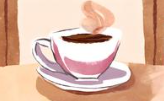

<a id="10"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">TO DO LIST</span>
1. I **NEED** to do better EDA. I've done some cursory EDA outside of this notebook, but seriously I need to step my EDA game up.
    - I've taken a look at other grandmaster's in my Kaggle book and so many of their claims to fame are just simple, good EDA
    - I think this is the biggest part of my data science skillset that I can improve upon. 
2. Easiest thing for me to do next is apply some of my optuned params to blending, voting, stacking, and mixing
3. Find better weights either with the LAD routine that Oscar suggests, or even hill climbing. 
4. My CV routine is so bad. I need to understand more about different ways to do it. 
5. Apply different scaling routines with pipelines to make it clearer in my notebooks
6. Do some easy arithmetic feature engineering routines and identify some new key features. 
7. If there's anything else you think I can add, please leave a comment! 

In [17]:
%%time

# Blending

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

LGBM.fit(X, y)
lgbm_test = LGBM.predict(z)
lgbm_preds = pd.DataFrame(lgbm_test)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)

HGB.fit(X, y)
hgb_test = HGB.predict(z)
hgb_preds = pd.DataFrame(hgb_test)

lgbm_w = 2
hgb_w = 1

blending_preds = ((lgbm_w * lgbm_preds) + (hgb_w * hgb_preds)) / (lgbm_w + hgb_w)

sample['Hardness'] = blending_preds
print(sample.head(3))

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
      id  Hardness
0  10407  2.541984
1  10408  2.626141
2  10409  6.067269
CPU times: user 8.67 s, sys: 4.65 s, total: 13.3 s
Wall time: 11.2 s


In [18]:
%%time


# Voting

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)

voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM),('HGB', HGB)],
                                   n_jobs = -1, 
                                   weights = [2, 1])

voter = voting_regressor.fit(X, y)
voting_preds = voter.predict(z)

sample['Hardness'] = voting_preds
print(sample.head(3))

sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
      id  Hardness
0  10407  2.541984
1  10408  2.626141
2  10409  6.067269

File submitted...
You've earned yourself a coffee...
CPU times: user 8.82 s, sys: 4.71 s, total: 13.5 s
Wall time: 11.6 s


In [19]:
%%time

# Voting, Stacking, and mixing

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=42,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=42, 
                                    loss='absolute_error',
                                    **hgb_params)


voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM),('HGB', HGB)],
                                   n_jobs = -1, 
                                   weights = [2, 1])

voter = voting_regressor.fit(X, y)
voting_preds = voter.predict(z)
sample['Hardness'] = voting_preds
voting_preds = pd.DataFrame(voting_preds, columns=['Hardness'])

stacking_regressor = StackingRegressor(estimators = [('LGBM', LGBM), ('HGB', HGB)],
                                        n_jobs = -1, 
                                        final_estimator = LADRegression())

stacker = stacking_regressor.fit(X, y)
stacking_preds = stacker.predict(z)
sample['Hardness'] = stacking_preds
stacking_preds = pd.DataFrame(stacking_preds, columns=['Hardness'])

voting_w = 0.6
stacking_w = 0.4

mixing_preds = ((voting_w * voting_preds) + (stacking_w * stacking_preds)) / (voting_w + stacking_w)
sample['Hardness'] = mixing_preds
mixing_preds = pd.DataFrame(mixing_preds, columns=['Hardness'])

print("voting_preds:")
print(voting_preds.head(3))
print("stacking preds:")
print(stacking_preds.head(3))
print("mixing preds:")
print(mixing_preds.head(3))

sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724